# Get Journalist Tweets

In [1]:
import sys
import os
from tqdm import tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import decomposition as skd
from sklearn import feature_extraction as skfe

In [2]:
sys.path.insert(1, '../')

In [3]:
from src.data import journalists as journos
from src.data.api_tweepy import connect_API
from src.data import api_tweet_tools as att
from src.data import data_cleanup as dc
from src.topics import hashtag_analysis as ha

In [4]:
keyword = 'cyber'
journo_handles = journos.get_handles_by_keyword(keyword)
print(len(journo_handles))

12


In [5]:
print(journo_handles)

['jennystrasburg', 'dannsimmons', 'LeoKelion', 'gordoncorera', 'joetidy', '_lucyingham', 'dannyjpalmer', 'SophiaFurber', 'SCFGallagher', 'MsHannahMurphy', 'JesscaHaworth', 'Ad_Nauseum74']


In [6]:
api_keys_fp = '../data/twitter_credentials.json'
tw_api = connect_API(api_keys_fp)

In [ ]:
att.batch_request_user_timeline(tw_api, journo_handles, '../data/raw/cyber_tweets/', api_delay=0.2, n_tweets=3200)

# Clean Journalist Tweets

In [ ]:
src_dir = '../data/raw/cyber_tweets/'
dest_dir = '../data/cleaned/cyber_tweets/'

if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

files = [file for file in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, file))]

with tqdm(total=len(files), desc='Files') as pbar:
    for file in files:
        raw_df = pd.read_csv(os.path.join(src_dir, file), low_memory=False)
        cleaned_df = dc.clean_API_dataframe(raw_df)
        cleaned_df.to_csv(os.path.join(dest_dir, file), index=False)
        pbar.update(1)

# Use hashtags to identify topics

In [5]:
src_dir = 'D:/S2DS/Ditchley/Aug20_Ditchley/data/cleaned/cyber_tweets/'

files = [file for file in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, file))] # build list of files to iterate through

data = pd.DataFrame()

with tqdm(total=len(files), desc='Files', file=sys.stdout) as pbar:
    for file in files:
        df = pd.read_csv(os.path.join(src_dir, file), low_memory=False)
        data = pd.concat([data, df[['screen_name', 'tweet_id', 'text', 'hashtags']]], axis=0, ignore_index=True)
        pbar.update(1)

Files: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


In [6]:
data = data[data['hashtags'].astype(str) != '[]'] # remove empties
data['text'] = data['text'].apply(lambda x: x.lower() if isinstance(x, str) else '')
data

,screen_name,tweet_id,text,hashtags
1,jennystrasburg,1298655692623142914,it s nationaljealousidonthaveadogday,['nationaljealousidonthaveadogday']
21,jennystrasburg,1295296427204186113,rt very excited to see today that blood and oi...,['bloodandoil']
75,jennystrasburg,1288463678367510533,rt approximately one fifth of covid patients a...,['covid']
77,jennystrasburg,1288228886774460417,rt today on thejournal the situation in rural ...,['thejournal']
93,jennystrasburg,1286391864195796994,new mexico public defenders prosecutors and ad...,['albuquerque']
...,...,...,...,...
28661,ad_nauseum74,1189939842064539648,rt bugbountyradar this month s top bug bounty ...,['bugbountyradar']
28676,ad_nauseum74,1187760868165144576,rt a ddos gang is impersonating known russian ...,"['ddos', 'fancybear']"
28679,ad_nauseum74,1187727565462618116,rt in this week s socialsec roundup breaches a...,['socialsec']
28681,ad_nauseum74,1187645968499597313,rt hackers are pretty much the same as sharks ...,['hacktivity2019']


In [7]:
hashtag_observations = ha.vectorize_wordlists(data['hashtags'])
hashtag_observations.info()
hashtag_observations.sparse.density

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3364 entries, 1 to 28693
Columns: 2014 entries, 11amfact to リテールテック
dtypes: Sparse[int64, 0](2014)
memory usage: 80.2 KB


0.0006795475665584663

Sum of the explained variance = 0.400.


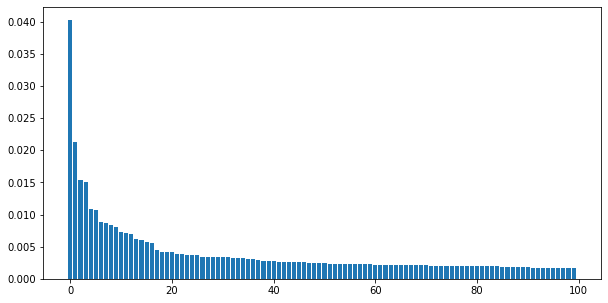

In [8]:
hashtag_dimred, svd_comps = ha.SVD_on_vectors(hashtag_observations, n_components=100)

In [9]:
topics = ha.make_topic_keywords_from_svd(svd_comps, threshold=0.2)
topics

,keywords
topic,
0,"[ces, samsung]"
1,[baselworld2015]
2,"[coronavirus, cybersecurity]"
3,[cybersecurity]
4,"[brexit, fintech]"
...,...
95,"[assange, chooselies, covid_19, covidiots, cov..."
96,"[bugbountyradar, chooselies, covid_19, covidio..."
97,"[bhasia, chooselies, covid_19, covidiots, covi..."


In [14]:
data['labels'] = ha.label_data_by_topic(hashtag_dimred, 0.2)
labelled_data = data
labelled_data

,screen_name,tweet_id,text,hashtags,labels
1,jennystrasburg,1298655692623142914,it s nationaljealousidonthaveadogday,['nationaljealousidonthaveadogday'],NaN
21,jennystrasburg,1295296427204186113,rt very excited to see today that blood and oi...,['bloodandoil'],NaN
75,jennystrasburg,1288463678367510533,rt approximately one fifth of covid patients a...,['covid'],68.0
77,jennystrasburg,1288228886774460417,rt today on thejournal the situation in rural ...,['thejournal'],NaN
93,jennystrasburg,1286391864195796994,new mexico public defenders prosecutors and ad...,['albuquerque'],NaN
...,...,...,...,...,...
28661,ad_nauseum74,1189939842064539648,rt bugbountyradar this month s top bug bounty ...,['bugbountyradar'],93.0
28676,ad_nauseum74,1187760868165144576,rt a ddos gang is impersonating known russian ...,"['ddos', 'fancybear']",NaN
28679,ad_nauseum74,1187727565462618116,rt in this week s socialsec roundup breaches a...,['socialsec'],NaN
28681,ad_nauseum74,1187645968499597313,rt hackers are pretty much the same as sharks ...,['hacktivity2019'],NaN


## Attempt to visualise the topic space

In [17]:
import plotly.express as px

In [13]:
from sklearn import manifold as skm

In [63]:
tsne = skm.TSNE(n_components=2, init='random',
                         random_state=0, n_jobs=6, perplexity=50, n_iter=5000, learning_rate=400)
tsneout = tsne.fit_transform(hashtag_dimred)

In [64]:
labelled_data['tsne_x'] = tsneout[:,0]
labelled_data['tsne_y'] = tsneout[:,1]
labelled_data

,screen_name,tweet_id,text,hashtags,labels,tsne_x,tsne_y
1,jennystrasburg,1298655692623142914,it s nationaljealousidonthaveadogday,['nationaljealousidonthaveadogday'],NaN,-15.599464,15.574455
21,jennystrasburg,1295296427204186113,rt very excited to see today that blood and oi...,['bloodandoil'],NaN,-7.793085,7.760643
75,jennystrasburg,1288463678367510533,rt approximately one fifth of covid patients a...,['covid'],68.0,-17.636230,-63.527199
77,jennystrasburg,1288228886774460417,rt today on thejournal the situation in rural ...,['thejournal'],NaN,2.622098,-55.026699
93,jennystrasburg,1286391864195796994,new mexico public defenders prosecutors and ad...,['albuquerque'],NaN,-8.479904,17.301741
...,...,...,...,...,...,...,...
28661,ad_nauseum74,1189939842064539648,rt bugbountyradar this month s top bug bounty ...,['bugbountyradar'],93.0,42.344456,-45.504154
28676,ad_nauseum74,1187760868165144576,rt a ddos gang is impersonating known russian ...,"['ddos', 'fancybear']",NaN,-5.950953,-34.944035
28679,ad_nauseum74,1187727565462618116,rt in this week s socialsec roundup breaches a...,['socialsec'],NaN,2.485680,-49.293613
28681,ad_nauseum74,1187645968499597313,rt hackers are pretty much the same as sharks ...,['hacktivity2019'],NaN,-52.456223,29.352140


In [92]:
viz = labelled_data.dropna()
viz['labels'] = viz['labels'].astype(int).astype(str)
viz

C:\Users\rwhwe\.conda\envs\S2DS\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,screen_name,tweet_id,text,hashtags,labels,tsne_x,tsne_y
75,jennystrasburg,1288463678367510533,rt approximately one fifth of covid patients a...,['covid'],68,-17.636230,-63.527199
117,jennystrasburg,1283782639015559175,rt lost decade how bafin for years played down...,"['bafin', 'wirecard']",71,52.866638,-20.819571
176,jennystrasburg,1278645139011973120,rt germany said it would disband part of its e...,['germany'],86,-12.650033,-55.963203
187,jennystrasburg,1278217674724605952,rt breaking a man was arrested for holding a h...,"['breaking', 'hkindependence', 'causewaybay']",26,-46.970436,-27.841280
275,jennystrasburg,1288463678367510533,rt approximately one fifth of covid patients a...,['covid'],68,-17.636230,-63.527199
...,...,...,...,...,...,...,...
28634,ad_nauseum74,1202164001918070785,rt facebook s amanda rousseau opens bheu by re...,['bheu'],32,-62.547924,-19.411665
28635,ad_nauseum74,1202163931134996480,rt are you ready for bheu earlier this year we...,['bheu'],32,-64.600159,-18.392719
28637,ad_nauseum74,1202150273516478465,my second ever bheu starting shortly and first...,['bheu'],32,-62.547924,-19.411665
28659,ad_nauseum74,1191653702928601088,rt chinese hackers claim to be able to beat an...,['infosec'],82,43.562637,-65.937981


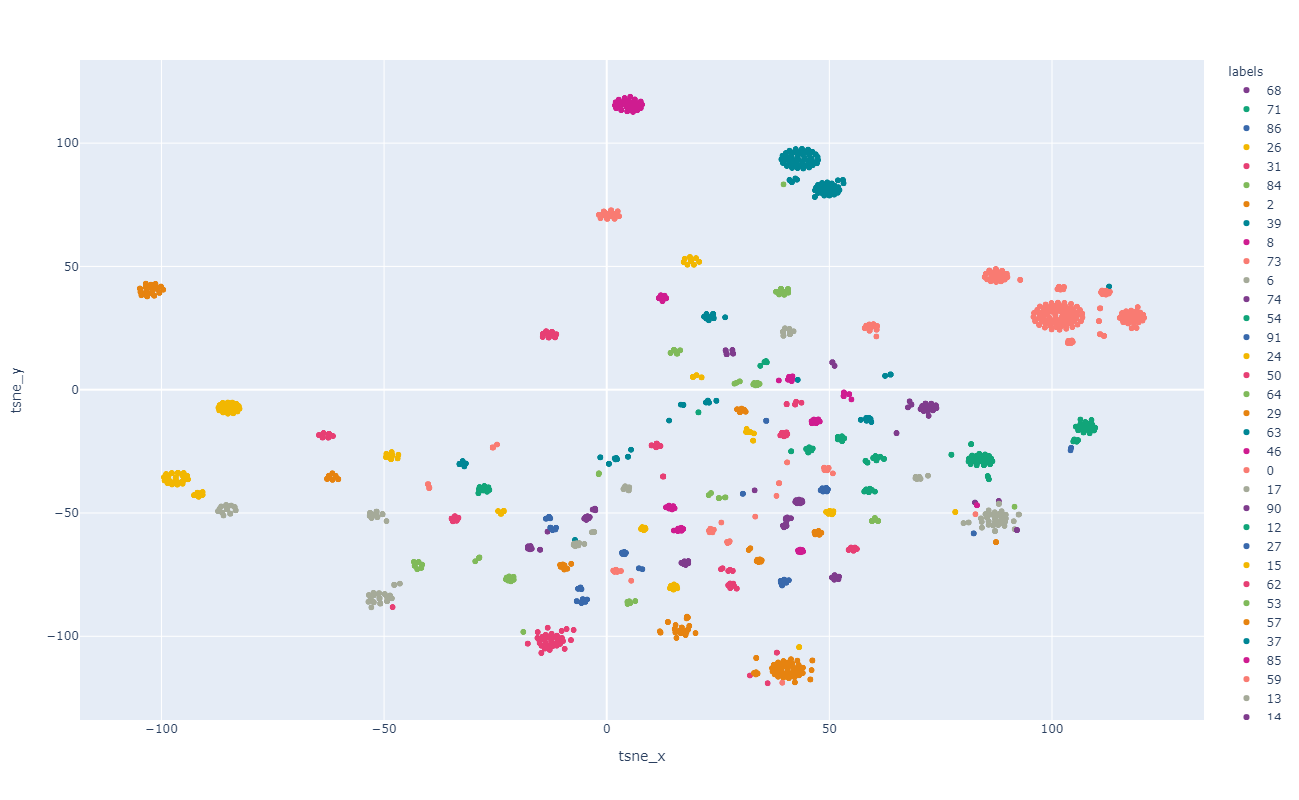

In [93]:
px.scatter(viz, 'tsne_x', 'tsne_y', color='labels',
          width=800,
          height=800,
          hover_name='screen_name',
          hover_data=['hashtags'],
          color_discrete_sequence=px.colors.qualitative.Bold)

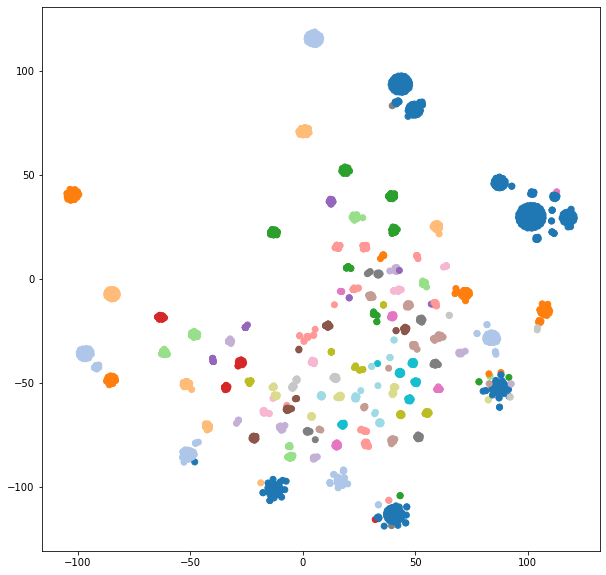

In [94]:
fig = plt.figure()
plt.scatter(viz['tsne_x'], viz['tsne_y'], c=viz['labels'].astype(int), cmap='tab20')
fig.set_size_inches(10,10)

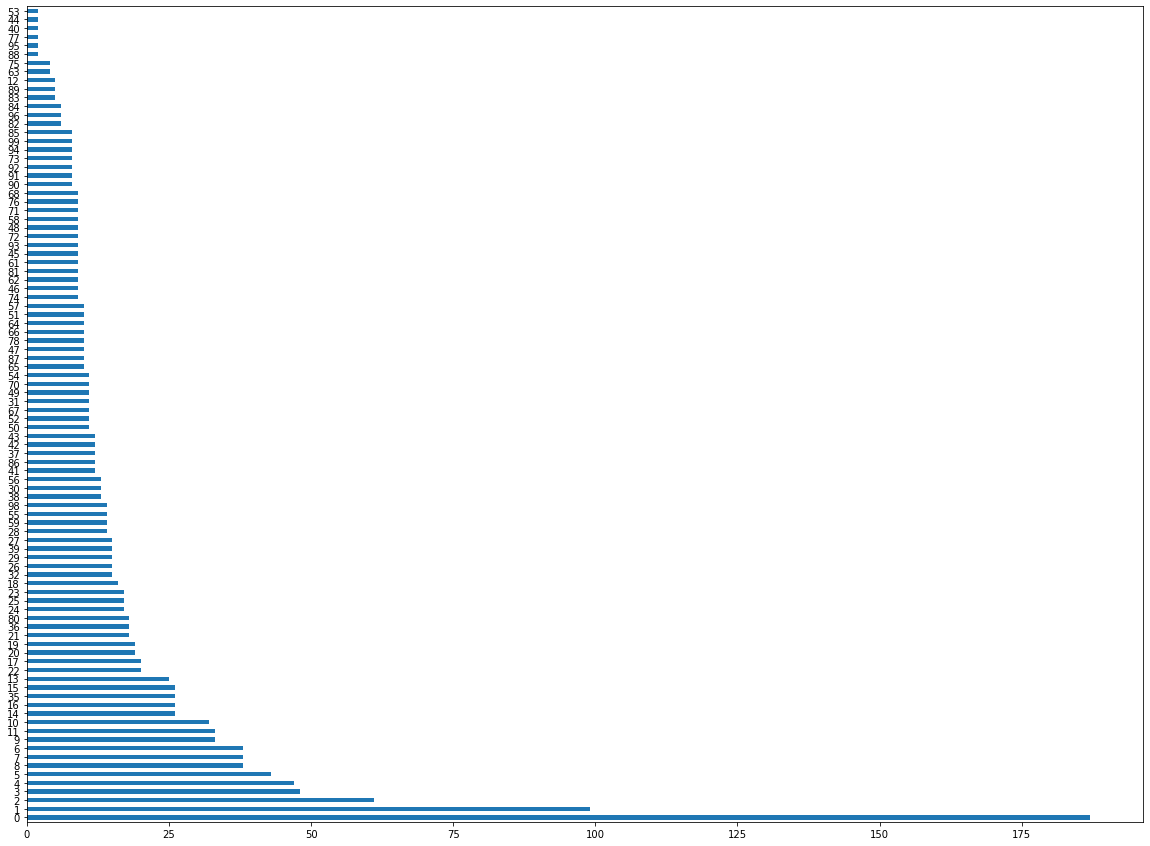

In [96]:
viz['labels'].value_counts().plot.barh()
fig = plt.gcf()
fig.set_size_inches(20,15)
#plt.xscale('log')
plt.show()

In [87]:
labelled_data.to_csv('../data/cleaned/labelled_cyber_journo_tweets.csv', index=False)
topics.to_csv('../data/cleaned/cyber_journo_topic_labels.csv', index=True)